# Models and Evaluation

In [1273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

USE_PURE_DATA = True
TRAIN_DATA_FILE = 'pure_data.csv' if USE_PURE_DATA else 'data.csv'

train_data = pd.read_csv('../assets/final/' + TRAIN_DATA_FILE)
test_data = pd.read_csv('../assets/final/kaggleData.csv')

print(train_data.shape)
print(test_data.shape)

(0, 13)
(354, 13)


In [1274]:
def get_features(df):
    return df.drop('paid', axis=1)
def get_target(df):
    return df.drop(df.columns.difference(['paid']), axis=1)

results = {}

### Split data

In [1275]:
def structure_data():
    ids_train = train_data['loan_id']
    ids_test = test_data['loan_id']

    train_data.drop(['loan_id'], axis=1, inplace=True)
    test_data.drop(['loan_id'], axis=1, inplace=True)

    train_features = get_features(train_data)
    train_target = get_target(train_data)
    test_features = get_features(test_data)
    test_target = get_target(test_data)

    return train_features, test_features, train_target, test_target, ids_train, ids_test


In [1276]:
_X_train, _X_test, _y_train, _y_test, ids_train, ids_test = structure_data()

print('\nTrain data shape: ', _X_train.shape)
print('\nTest data shape: ', _X_test.shape)
print('\nTrain shape:',_y_train.shape)
print('\nTest shape:',_y_test.shape)



Train data shape:  (0, 11)

Test data shape:  (354, 11)

Train shape: (0, 1)

Test shape: (354, 1)


### Resampling

In [1277]:
def oversample(X_train, y_train):
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=1, sampling_strategy=1.0)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    return X_train, y_train

In [1278]:
_smote_X_train, _smote_y_train = oversample(_X_train, _y_train)

print('\nTrain data shape: ', _smote_X_train.shape)
print('\nTrain shape:',_smote_y_train.shape)


IndexError: index 0 is out of bounds for axis 0 with size 0

### Algorithms

In [ ]:
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold, StratifiedKFold

k = 5
kr = 3
cv = RepeatedStratifiedKFold(n_splits=k, n_repeats=kr, random_state=0)

scoring = {"accuracy": "accuracy",
           "precision": "precision",
           "recall": "recall",
           "f1": "f1",
           "roc_auc": "roc_auc"}

In [ ]:
import datetime    

# Trains a specific Model
def add_model(name, model, use_smote=False):
    x_fit_data = _smote_X_train.copy() if use_smote else _X_train.copy()
    y_fit_data = _smote_y_train if use_smote else _y_train

    X_test = _X_test.copy()

    start = datetime.datetime.now()
    
    model.fit(x_fit_data, np.ravel(y_fit_data.values))

    # Folding data and fitting. This overwrites previous results and by some magic gives better results :)
    """ skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
    for train_index, test_index in skf.split(x_fit_data, y_fit_data):
        #print("TRAIN:", x_fit_data.iloc[train_index], "TEST:", y_fit_data.iloc[train_index].values)
        model.fit(x_fit_data.iloc[train_index], np.ravel(y_fit_data.iloc[train_index].values)) """
        
    end = datetime.datetime.now()

    results[name] = {'model': model,
                    'X_test': X_test, 
                    'fit_time': (end - start).microseconds / 1000 # time difference in milliseconds
                    }

In [ ]:
USE_SMOTE = False

In [ ]:
from sklearn.tree import DecisionTreeClassifier
add_model('dtc',
    DecisionTreeClassifier(),
    use_smote=USE_SMOTE
)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
add_model('knn',
    KNeighborsClassifier(),
    use_smote=USE_SMOTE
)

In [ ]:
from sklearn.neural_network import MLPClassifier
add_model('mlp',
    MLPClassifier(),
    use_smote=USE_SMOTE
)

In [ ]:
from sklearn.naive_bayes import GaussianNB
add_model('gnb',
    GaussianNB(),
    use_smote=USE_SMOTE
)

In [ ]:
from sklearn.svm import SVC
add_model('svc',
    SVC(probability=True),
    use_smote=USE_SMOTE
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

add_model('rf',
    RandomForestClassifier(criterion='entropy', max_depth=6, max_features='sqrt', n_estimators=150),#criterion='entropy', max_depth=3, max_features='sqrt', n_estimators=150),
    use_smote=USE_SMOTE
)

In [ ]:
from sklearn.linear_model import LogisticRegression

add_model('lr',
    LogisticRegression(),
    use_smote=USE_SMOTE
)

## Prediction

# TODO:
- Stratified Cross-Validation. Turns out this would only make sense to test the model with the training data.
- Check if SMOTE should be applied
- Test different models
- Clustering
- Outliers
- Check Inputation
- Improve predictions

In [ ]:
def predict(name):
    result = results[name]
    pred = result['model'].predict(result['X_test'])
    result['test_pred'] = pred

for name in results.keys():
    # Predict paid column on test data
    predict(name)

In [ ]:
def predict_proba(name):
    result = results[name]
    proba = result['model'].predict_proba(result['X_test'])
    result['test_pred_prob'] = proba

for name in results.keys():
    # Predict paid column on test data (Probability)
    predict_proba(name)

In [ ]:
# Check result object
'''
test_pred -> Prediction of paid column on test data
trainpred -> Prediction of paid column on train data

test_pred_prob -> Prediction of Probability of paid column on test data
trainpred_prob -> Prediction of Probability of paid column on train data
'''
results

{'dtc': {'model': DecisionTreeClassifier(),
  'X_test':      is_co-owned  gender  a_district  a_region  a_avg_salary  payments  \
  0              0       1    0.971951  0.923409          8390      1566   
  1              0       0    0.859756  0.801928          8620      7240   
  2              0       0    0.976626  0.808117         10045      4845   
  3              1       0    0.964939  0.891046          8899      3698   
  4              0       1    0.619919  0.923409          8388      3210   
  ..           ...     ...         ...       ...           ...       ...   
  349            0       0    0.571951  0.808117          9104      7348   
  350            0       1    0.979965  0.882025          8743      4376   
  351            0       1    0.953252  0.891046          8980      5812   
  352            0       1    0.896341  0.766534         10177      2318   
  353            0       0    0.694251  0.882025          8441      4015   
  
       balance_min  balance_mea

### Check Prediction Results

In [ ]:
used_ml_model = 'lr'

In [ ]:
print("ML Model analyzed: ", used_ml_model)
print(results[used_ml_model]['test_pred_prob'])

ML Model analyzed:  rf
[[0.00376562 0.99623438]
 [0.44398428 0.55601572]
 [0.04979595 0.95020405]
 [0.00635777 0.99364223]
 [0.48015621 0.51984379]
 [0.18099719 0.81900281]
 [0.01514702 0.98485298]
 [0.05454112 0.94545888]
 [0.01871418 0.98128582]
 [0.30308759 0.69691241]
 [0.00840478 0.99159522]
 [0.02230989 0.97769011]
 [0.0438808  0.9561192 ]
 [0.46688216 0.53311784]
 [0.12868604 0.87131396]
 [0.37088524 0.62911476]
 [0.01686446 0.98313554]
 [0.04839759 0.95160241]
 [0.04271995 0.95728005]
 [0.01580473 0.98419527]
 [0.37411258 0.62588742]
 [0.10582363 0.89417637]
 [0.3493393  0.6506607 ]
 [0.30381711 0.69618289]
 [0.07643939 0.92356061]
 [0.01750797 0.98249203]
 [0.37559887 0.62440113]
 [0.08073839 0.91926161]
 [0.03544006 0.96455994]
 [0.03544006 0.96455994]
 [0.01579027 0.98420973]
 [0.01923007 0.98076993]
 [0.00985986 0.99014014]
 [0.06311308 0.93688692]
 [0.01021607 0.98978393]
 [0.04364854 0.95635146]
 [0.01164726 0.98835274]
 [0.19469922 0.80530078]
 [0.05701537 0.94298463]
 [

### Save the predictions results

In [ ]:
import os

RES_PATH = '../assets/results'
if not os.path.exists(RES_PATH):
  os.mkdir(RES_PATH)

res = {'Id': ids_test.values, 'Predicted': results[used_ml_model]['test_pred_prob'][:,0]}

df = pd.DataFrame(data=res)
df.to_csv(RES_PATH + '/submission.csv', index=False)

df

,Id,Predicted
0,5895,0.003766
1,7122,0.443984
2,6173,0.049796
3,6142,0.006358
4,5358,0.480156
...,...,...
349,4989,0.573456
350,5221,0.014193
351,6402,0.010460
352,5346,0.223076


In [ ]:
# function that opens RES_PATH + '/submission.csv' and round the Predict table in 1 decimal place
# TODO: WHAT IS THIS FOR??
def submission():
  import pandas as pd
  RES_PATH = '../assets/results'
  df = pd.read_csv(RES_PATH + '/submission.csv')
  df.to_csv(RES_PATH + '/submission.csv', index=False)

# submission()

## Evaluate Prediction with ROC Curve

Submission score: 0.8149176954732511% (~0.81%)


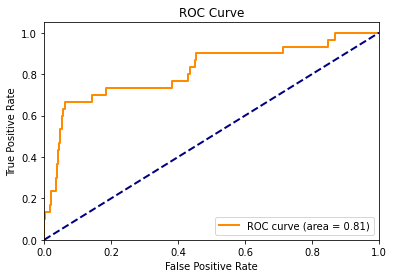

In [ ]:
import pandas as pd

SHOW_GRAPH = True

SUBMISSION_PATH = "../assets/results/submission.csv"
RESULTS_PATH = "../assets/complete_clean/loan_dev.csv"

submission_pd = pd.read_csv(SUBMISSION_PATH)
results_pd = pd.read_csv(RESULTS_PATH)
mix_pd = pd.merge(submission_pd, results_pd, left_on='Id', right_on='loan_id', how='inner')

submission_scores = mix_pd["Predicted"].values.tolist()
results = mix_pd["paid"].values.tolist()

fpr, tpr, thresholds = roc_curve(results, submission_scores, pos_label=0)
auc = auc(fpr, tpr)

print(f"Submission score: {auc}% (~{round(auc, 2)}%)")

if SHOW_GRAPH:
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


---------------------